# Helion Kernel Development & Benchmark with Triton, Torch

[Helion](https://github.com/pytorch/helion) is a Python-embedded domain-specific language (DSL) for authoring machine learning kernels, designed to compile down to Triton, a performant backend for programming GPUs and other devices. Helion aims to raise the level of abstraction compared to Triton, making it easier to write correct and efficient kernels while enabling more automation in the autotuning process.

Helion can be viewed either as PyTorch with tiles or as a higher-level Triton. Compared to Triton, Helion reduces manual coding effort through autotuning. Helion spends more time (approx 10 min) autotuning as it evaluates hundreds of potential Triton implementations generated from a single Helion kernel. This larger search space also makes kernels more performance portable between different hardware. 

Helion has been supported by AMD GPUs. This workshop will demonstrate how to set up the Helion development environment and develop Helion Kernel, and benchmark performance with Triton and Torch on AMD MI GPU. 




### Agenda:
- 1. Set up Helion Development Enviroment 

- 2. The Origin of Softmax Algorithm

- 3. Helion Softmax GPU Kernel Authoring

- 4. Helion VS. Triton VS. Torch Performance Benchmark & Visualization on AMD GPU


## 1. Set up Helion development enviroment 
 

### Step1: Access AMD MI GPU 
In this workshop, we will use the **MI GPU** cloud instance from AMD Developer Cloud. Please access your GPU instance link, which has been provided by this workshop.

### Step2: Run ROCm Official Container on GPU card 
In this workshop, we will work on the pre-built ROCm PyTorch image, which pulled with command 'docker pull rocm/pytorch:rocm7.0.2_ubuntu24.04_py3.12_pytorch_release_2.8.0'. It has integrated Pytorch with AMD ROCm software stack succeffully. Developers can also try other ROCm as the base image docker hub page from [docker images](https://hub.docker.com/r/rocm/pytorch/tags) if need. 

### Step3: Install OpenAI Helion and Triton

####    Uninstall the old Helion & Triton
It is strongly recommended to use the latest version Helion in your project, because AMD and other vendors are updating their optimization passes and algorithms frequently in [Meta Helion](https://github.com/pytorch/helion) , which can help improve your Helion kernel performance. 


In [1]:
!pip uninstall -y helion triton

Found existing installation: helion 0.2.1
Uninstalling helion-0.2.1:
  Successfully uninstalled helion-0.2.1
Found existing installation: triton 3.4.0+rocm7.0.0.git56765e8c
Uninstalling triton-3.4.0+rocm7.0.0.git56765e8c:
  Successfully uninstalled triton-3.4.0+rocm7.0.0.git56765e8c


#### Install Meta PyTorch, Meta Helion and OpenAI Triton


In [2]:
%%bash

# if not docker based, pls uncomment below line:
# pip install torch==2.8.0 torchvision==0.23.0 torchaudio==2.8.0 --index-url https://download.pytorch.org/whl/rocm6.4
pip install triton
pip install helion
pip install matplotlib

pip list | grep -E 'helion|triton|torch'

# Pls ignore the incompatible error which will not  affect the examples' exection in this notebook.
# Confirm it install successfully by showing 'Successfully installed triton-xxx'.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 MB 76.1 MB/s  0:00:02m0:00:0100:01


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0.dev20250821+rocm7.0.0.lw.git125803b7 requires triton==3.4.0+rocm7.0.0.git56765e8c; platform_system == "Linux" and platform_machine == "x86_64", but you have triton 3.5.1 which is incompatible.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


  Using cached helion-0.2.1-py3-none-any.whl.metadata (20 kB)
Using cached helion-0.2.1-py3-none-any.whl (283 kB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


helion                    0.2.1
torch                     2.9.0.dev20250821+rocm7.0.0.lw.git125803b7
torchao                   0.13.0+gita9ffa508e
torchaudio                2.8.0+rocm7.0.0.git0c223473
torchdata                 0.11.0
torchprofile              0.0.4
torchtitan                0.0.2                                      /workspace/torchtitan
torchtune                 0.0.0                                      /workspace/torchtune
torchvision               0.24.0+rocm7.0.0.git98f8b375
triton                    3.5.1


## 2. The Origin of Softmax Algorithm

The softmax function, often used in classification CNN models and even Transformer based LLM models,converts raw output scores or logits, into probabilities by taking the exponential of each value and normalizing these values by dividing by the sum of all the exponentials. This process ensures that the output values are in the range (0,1) and sum up to 1, making them interpretable as probabilities. PyTorch has implemented it as [a standard API](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html). 

Definition of function $y = Softmax(x)$ is:

$$
y_i = \frac{e^{x_i}}{\sum_{j=1}^{V} e^{x_j}} \tag{1}
$$

where $x,y \in \mathbb{R}^V$.

### Naive version - Safe-Softmax

To achieve the numerical stability, we need to subtract the maximum value of the row vector from each input element before taking their exponentials. So the definition changes to:

$$
y_i = 
\frac{e^{\left(x_i - \max_{k=1}^V x_k\right)}}
     {\sum_{j=1}^V e^{\left(x_j - \max_{k=1}^V x_k\right)}} \tag{2}
$$

where $x,y \in \mathbb{R}^V$. This is called `Safe Softmax`.

According to the softmax algorithm definition `(Equation 2)`, we implemented the naive version Triton kernel. To get the maximum data and the corresponding sum of all the exponentials, 2 for-loops are implemented in this version kernel, and there is still 1 for-loop to calculate the final softmax result. So total 3 loops are used in this kernel. The algorithm of `Safe Softmax` (from [this paper](https://arxiv.org/pdf/1805.02867)) is:

![safe_softmax](./assets/safe_softmax_algo.png)

Assuming that we need to test this kernel performance on an 8192x8192 tensor. We will conduct the calculation like this:

![softmax_naive](./assets/softmax_naive_50p.png)

- The block size of col dimension is 256.
- We allocate one program per row of the input tensor, which means the grid size is (n_rows,) where n_rows equals number of rows of input tensor.
- The program instance (thread block) scans one row of the tensor and iteratively process the data blocks of current row, to calculate the maximum value $m_k$ of current row. This is 1st for-loop.
- The program instance (thread block) scans one row of the tensor and iteratively process the data blocks of current row, to calculate the denominator (sum of exponentials) value $d_j$ of current row. This is 2nd for-loop.
- The program instance (thread block) scans one row of the tensor and iteratively process the data blocks of current row, to calculate the final softmax value $y_i$ of current row. This is 3rd for-loop.

## 3. Helion Two-pass Softmax 
This example demonstrates multiple Helion kernel implementations of the softmax function,
including a simple wrapper around PyTorch's softmax, and a numerically optimized two-pass version.
The example also includes a check function to compare these kernels against PyTorch's
built-in softmax for correctness.

In [6]:

import torch
import helion
from helion._testing import run_example
import helion.language as hl

# %%
@helion.kernel(autotune_effort="quick")
def softmax_two_pass(x: torch.Tensor) -> torch.Tensor:
    """
    Numerically optimized Helion kernel performing softmax in two passes.
    Args:
        x (torch.Tensor): Input tensor of shape [m, n].
    Returns:
        torch.Tensor: Softmax output tensor of the same shape.
    """
    m, n = x.size()
    out = torch.empty_like(x)
    block_size_m = hl.register_block_size(m)
    block_size_n = hl.register_block_size(n)
    for tile_m in hl.tile(m, block_size=block_size_m):
        mi = hl.full([tile_m], float("-inf"), dtype=torch.float32)
        di = hl.zeros([tile_m], dtype=torch.float32)
        for tile_n in hl.tile(n, block_size=block_size_n):
            values = x[tile_m, tile_n]
            local_amax = torch.amax(values, dim=1)
            mi_next = torch.maximum(mi, local_amax)
            di = di * torch.exp(mi - mi_next) + torch.exp(
                values - mi_next[:, None]
            ).sum(dim=1)
            mi = mi_next
        for tile_n in hl.tile(n, block_size=block_size_n):
            values = x[tile_m, tile_n]
            out[tile_m, tile_n] = torch.exp(values - mi[:, None]) / di[:, None]
    return out


# %%
def check(m: int, n: int) -> None:
    """
    Runs correctness checks comparing Helion softmax kernels against PyTorch's softmax.
    Args:
        m (int): Number of rows in input tensor.
        n (int): Number of columns in input tensor.
    """
    x = torch.randn([m, n], device="cuda", dtype=torch.float16)
    run_example(softmax_two_pass, lambda x: torch.nn.functional.softmax(x, dim=1), (x,))


# %%
def main() -> None:
    """
    Main function to run the softmax kernel correctness check with example input size.
    """
    check(4096, 2560)


# %%
if __name__ == "__main__":
    main()


Testing helion correctness...
[0s] Autotune random seed: 1978983859
[0s] Starting autotuning process, this may take a while...
[0s] Starting PatternSearch with initial_population=30, copies=2, max_generations=5


Output()

[60s] Timeout after 60s compiling Config(block_sizes=[32, 4096], indexing=['tensor_descriptor', 'tensor_descriptor', 'tensor_descriptor'], load_eviction_policies=['', 'first'], num_stages=1, num_warps=1, pid_type='persistent_blocked', range_flattens=[True, None], range_multi_buffers=[True, None], range_num_stages=[1, 4], range_unroll_factors=[4, 2], range_warp_specializes=[])
[60s] Timeout after 60s compiling Config(block_sizes=[2048, 64], indexing=['pointer', 'pointer', 'tensor_descriptor'], load_eviction_policies=['first', ''], num_stages=8, num_warps=4, pid_type='persistent_blocked', range_flattens=[None, False], range_multi_buffers=[None, False], range_num_stages=[3, 3], range_unroll_factors=[3, 1], range_warp_specializes=[])


Output()

[62s] Initial random population of 30, 2 starting points: error=10 timeout=2 ok=18 min=0.0277 mid=0.3647 max=7.9801 best=Config(block_sizes=[1, 1024], indexing=['tensor_descriptor', 'pointer', 'tensor_descriptor'], load_eviction_policies=['first', 'last'], num_stages=1, num_warps=4, pid_type='flat', range_flattens=[None, None], range_multi_buffers=[None, False], range_num_stages=[0, 4], range_unroll_factors=[0, 1], range_warp_specializes=[])
[62s] Generation 1 starting: 52 neighbors, 2 active search path(s)


Output()

Output()

[68s] Generation 1 complete: ok=54 min=0.0254 mid=0.0651 max=0.1297 best=Config(block_sizes=[2, 512], indexing=['tensor_descriptor', 'pointer', 'tensor_descriptor'], load_eviction_policies=['first', 'last'], num_stages=1, num_warps=4, pid_type='flat', range_flattens=[None, None], range_multi_buffers=[None, False], range_num_stages=[0, 4], range_unroll_factors=[0, 1], range_warp_specializes=[])
[68s] Generation 2 starting: 49 neighbors, 2 active search path(s)


Output()

Output()

[73s] Generation 2 complete: ok=51 min=0.0247 mid=0.0429 max=0.0847 best=Config(block_sizes=[4, 512], indexing=['tensor_descriptor', 'pointer', 'tensor_descriptor'], load_eviction_policies=['first', 'last'], num_stages=1, num_warps=4, pid_type='flat', range_flattens=[None, None], range_multi_buffers=[None, False], range_num_stages=[0, 4], range_unroll_factors=[0, 1], range_warp_specializes=[])
[73s] Generation 3 starting: 47 neighbors, 2 active search path(s)


Output()

Output()

[78s] Generation 3 complete: ok=49 min=0.0243 mid=0.0318 max=0.0662 best=Config(block_sizes=[4, 512], indexing=['tensor_descriptor', 'pointer', 'tensor_descriptor'], load_eviction_policies=['first', 'last'], num_stages=1, num_warps=4, pid_type='flat', range_flattens=[None, None], range_multi_buffers=[None, False], range_num_stages=[0, 4], range_unroll_factors=[0, 0], range_warp_specializes=[])
[78s] Generation 4 starting: 49 neighbors, 2 active search path(s)


Output()

Output()

[83s] Generation 4 complete: ok=51 min=0.0243 mid=0.0299 max=0.0588 best=Config(block_sizes=[4, 512], indexing=['tensor_descriptor', 'pointer', 'tensor_descriptor'], load_eviction_policies=['first', 'last'], num_stages=1, num_warps=4, pid_type='flat', range_flattens=[None, None], range_multi_buffers=[None, False], range_num_stages=[0, 4], range_unroll_factors=[0, 0], range_warp_specializes=[])
[83s] Generation 5 starting: 23 neighbors, 1 active search path(s)


Output()

Output()

[86s] Generation 5 complete: ok=25 min=0.0243 mid=0.0262 max=0.0451 best=Config(block_sizes=[4, 512], indexing=['tensor_descriptor', 'pointer', 'tensor_descriptor'], load_eviction_policies=['first', 'last'], num_stages=1, num_warps=4, pid_type='flat', range_flattens=[None, None], range_multi_buffers=[None, False], range_num_stages=[0, 4], range_unroll_factors=[0, 0], range_warp_specializes=[])
[86s] Autotuning complete in 86.7s after searching 248 configs.
One can hardcode the best config and skip autotuning with:
    @helion.kernel(config=helion.Config(block_sizes=[4, 512], indexing=['tensor_descriptor', 'pointer', 'tensor_descriptor'], load_eviction_policies=['first', 'last'], num_stages=1, num_warps=4, pid_type='flat', range_flattens=[None, None], range_multi_buffers=[None, False], range_num_stages=[0, 4], range_unroll_factors=[0, 0], range_warp_specializes=[]), static_shapes=True)



Output()


Benchmark Results
Implementation       Time (ms)    Speedup        
-----------------------------------------------------------------
helion               0.0286       0.89x          
torch                0.0255       1.00x (ref)    



## 4. Performance Benchmark & Visualization: Helion vs. Triton vs. PyTorch 

### Control Group: Triton Fused-Softmax 
This example demonstrates how to implement a fused softmax kernel using Triton, with architectural awareness for AMD ROCm/CDNA backends.

OpenAI Triton provided a reference softmax sample codes with the name of "fused-softmax". Based on online softmax, it continued to simplify the maxmumim data calculation, which can remove 1 for-loop. it also ask the compiler to use more threads per row by increasing the number of warps, which is often tuned for better performance. and finally it improved the kernel lauching scheme by the GPU hardware properties, which can have the higher GPU kernel occupancy and better performance.  


In [3]:
import torch
import triton
import triton.language as tl
from triton.runtime import driver

DEVICE = triton.runtime.driver.active.get_active_torch_device()

def is_hip():
    return triton.runtime.driver.active.get_current_target().backend == "hip"


def is_cdna():
    return is_hip() and triton.runtime.driver.active.get_current_target().arch in ('gfx940', 'gfx941', 'gfx942',
                                                                                   'gfx90a', 'gfx908', 'gfx950')

@triton.jit
def fused_softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, BLOCK_SIZE: tl.constexpr,
                   num_stages: tl.constexpr):
    # starting row of the program
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        # The stride represents how much we need to increase the pointer to advance 1 row
        row_start_ptr = input_ptr + row_idx * input_row_stride
        # The block size is the next power of two greater than n_cols, so we can fit each
        # row in a single block
        col_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = row_start_ptr + col_offsets
        # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
        mask = col_offsets < n_cols
        row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
        # Subtract maximum for numerical stability
        row_minus_max = row - tl.max(row, axis=0)
        # Note that exponentiation in Triton is fast but approximate (i.e., think __expf in CUDA)
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator, axis=0)
        softmax_output = numerator / denominator
        # Write back output to DRAM
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        output_ptrs = output_row_start_ptr + col_offsets
        tl.store(output_ptrs, softmax_output, mask=mask)

# To tune the kernel, we first get some resource properties of our GPU by:
properties = driver.active.utils.get_device_properties(DEVICE.index)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}
print(f"NUM_SM: {NUM_SM}, NUM_REGS: {NUM_REGS}, SIZE_SMEM: {SIZE_SMEM}, WARP_SIZE: {WARP_SIZE}, target: {target}")

# Then we setup the kernel launch configuration
torch.manual_seed(0)
x = torch.randn(8192, 8192, device=DEVICE)
output_torch = torch.softmax(x, dim=-1)
n_rows, n_cols = x.shape
# Allocate output
y = torch.empty_like(x)

# The block size of each loop iteration is the smallest power of two greater than the number of columns in `x`
BLOCK_SIZE = triton.next_power_of_2(n_cols*2)

# Another trick we can use is to ask the compiler to use more threads per row by
# increasing the number of warps (`num_warps`) over which each row is distributed.
num_warps = 8

# Number of software pipelining stages.
num_stages = 4 if SIZE_SMEM > 200000 else 2

print(f"BLOCK_SIZE: {BLOCK_SIZE}, num_warps: {num_warps}, num_stages: {num_stages}")

# The occupancy of the kernel is limited by register usage. To maximize the occupancy, let's warmup the kernel to get register usage, and calculate the proper programs number.

# pre-compile kernel to get register usage and compute thread occupancy.
kernel = fused_softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
kernel._init_handles()
n_regs = kernel.n_regs
size_smem = kernel.metadata.shared

if is_hip():
    # NUM_REGS represents the number of regular purpose registers. On CDNA architectures this is half of all registers available.
    # However, this is not always the case. In most cases all registers can be used as regular purpose registers.
    # ISA SECTION (3.6.4 for CDNA3)
    # VGPRs are allocated out of two pools: regular VGPRs and accumulation VGPRs. Accumulation VGPRs are used
    # with matrix VALU instructions, and can also be loaded directly from memory. A wave may have up to 512 total
    # VGPRs, 256 of each type. When a wave has fewer than 512 total VGPRs, the number of each type is flexible - it is
    # not required to be equal numbers of both types.
    if is_cdna():
        NUM_GPRS = NUM_REGS * 2

    # MAX_NUM_THREADS represents maximum number of resident threads per multi-processor.
    # When we divide this number with WARP_SIZE we get maximum number of waves that can
    # execute on a CU (multi-processor)  in parallel.
    MAX_NUM_THREADS = properties["max_threads_per_sm"]
    max_num_waves = MAX_NUM_THREADS // WARP_SIZE
    occupancy = min(NUM_GPRS // WARP_SIZE // n_regs, max_num_waves) // num_warps
else:
    occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    
occupancy = min(occupancy, SIZE_SMEM // size_smem)
num_programs = NUM_SM * occupancy

num_programs = min(num_programs, n_rows)

print(f"n_regs: {n_regs}, size_smem: {size_smem}, occupancy: {occupancy}, num_programs: {num_programs}")


NUM_SM: 304, NUM_REGS: 65536, SIZE_SMEM: 65536, WARP_SIZE: 64, target: GPUTarget(backend='hip', arch='gfx942', warp_size=64)
BLOCK_SIZE: 16384, num_warps: 8, num_stages: 2
n_regs: 98, size_smem: 32, occupancy: 2, num_programs: 608



# Let's run the benchmark and visualization !


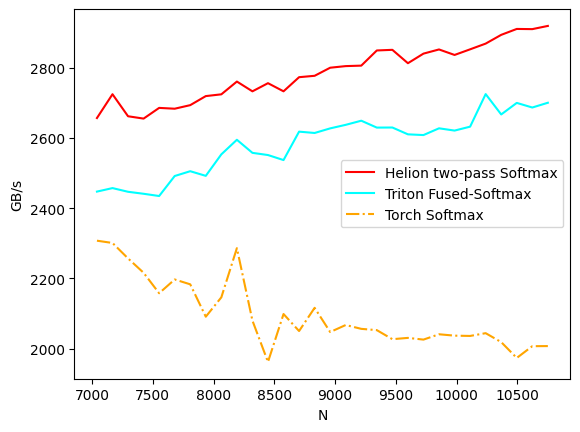

Softmax Performance Benchamrk:
          N  Helion two-pass Softmax  Triton Fused-Softmax  Torch Softmax
0    7040.0              2657.145414           2447.500532    2307.617214
1    7168.0              2724.964380           2457.505677    2301.130798
2    7296.0              2662.190158           2446.985081    2257.109803
3    7424.0              2655.521061           2441.314148    2216.175932
4    7552.0              2686.029975           2434.925706    2157.855420
5    7680.0              2683.696162           2491.912531    2197.120944
6    7808.0              2693.865215           2505.606954    2183.293643
7    7936.0              2719.657491           2492.362212    2091.030715
8    8064.0              2724.683411           2553.659101    2146.208144
9    8192.0              2761.085165           2595.184020    2286.366750
10   8320.0              2733.240131           2557.934340    2079.896910
11   8448.0              2756.443061           2551.679533    1962.163959
12   85

In [18]:
import torch
import torch.nn.functional as F
import triton
import triton.language as tl
import matplotlib.pyplot as plt

DEVICE = triton.runtime.driver.active.get_active_torch_device()

# --- Helion Softmax ---
def softmax_helion(x: torch.Tensor, dim=-1):
    helion_output=softmax_two_pass(x)
    return helion_output

# --- Helper to run Triton Autotune ---
def softmax_triton(x: torch.Tensor):
    n_rows, n_cols = x.shape
    triton_output = torch.empty_like(x)
    kernel[(num_programs, 1, 1)](
        y, 
        x, 
        x.stride(0), 
        y.stride(0), 
        n_rows, 
        n_cols, 
        BLOCK_SIZE, 
        num_stages)
    return triton_output

# --- PyTorch Naive Softmax ---
def softmax_torch(x: torch.Tensor, dim=-1):
    """
    Compute softmax using PyTorch built-in function.
    Output is the same shape as input.
    """
    torch_output = F.softmax(x, dim=dim)
    return torch_output



# --- Triton Benchmark ---
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[256 * i for i in range(30, 40)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['helion','triton', 'torch'],  # possible values for `line_arg`
        line_names=["Helion two-pass Softmax","Triton Fused-Softmax", "Torch Softmax"],  # label name for the lines
        styles=[('red', 'solid'),('cyan', 'solid'), ('orange', 'dashdot')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="Softmax Performance Benchamrk",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    
    quantiles = [0.5, 0.2, 0.8]
    
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: torch.softmax(x, dim=-1), rep=10, quantiles=quantiles
        )
    elif provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: softmax_triton(x), rep=10, quantiles=quantiles
        )
    elif provider == 'helion':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: softmax_helion(x), rep=10, quantiles=quantiles
        )
    # Calculate bandwidth: 2 * (read + write) * size / time
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)

# --- Run benchmark ---
benchmark.run(show_plots=True, print_data=True)


## Summary 
Helion simplifies high-performance GPU kernel development. Through this workshop, developer has already know how to develop and optimize Helion kernel on AMD GPUs. 

We hope that this workshop will encourage you to tune, test, and contribute to Helion on AMD GPUs, and help us shape the future of AI acceleration.   